In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymongo as pm
import pprint
from enum import Enum
from datetime import datetime, timedelta
import geojson
import seaborn as sb

# pd.set_option("display.max_columns", None)
# mpl.rcParams["figure.dpi"] = 100

In [96]:

client = pm.MongoClient('bigdatadb.polito.it',                     
                        ssl=True,                     
                        authSource = 'carsharing',                     
                        username = 'ictts',                     
                        password ='Ict4SM22!',                     
                        tlsAllowInvalidCertificates=True) 
db = client['carsharing'] 

#Choose the DB to use 
Ictts_enj_p_booking = db['ictts_enjoy_PermanentBookings']
Ictts_p_booking = db['ictts_PermanentBookings']

with open("TorinoZonescol.geojson") as f:
    gj = geojson.load(f)

In [97]:
#weekday - days 2-6 -morning 7-11 - afternoon 12-18
#weekend - days 1,7 -morning 7-12 - afternoon 13-18
def weekday_piper(start_hour,end_hour,origin_zone,destination_zone):
  return [
    { "$project":
     {
       "hour":{"$hour":"$init_date"},
       "day":{"$dayOfWeek":"$init_date"},
       "init_loc":1,
       "final_loc":1,
       "init_time":1
       }
    },
    { "$match": {
      "day":{"$gte":2,"$lte":6},
      "hour":{"$gte":start_hour,"$lte":end_hour},
      "init_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":origin_zone}}},
      "final_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":destination_zone}}}}
    },
    { "$count":"tot"}
  ]

def weekend_piper(start_hour,end_hour,origin_zone,destination_zone):
  return [
    { "$project":
     {
       "hour":{"$hour":"$init_date"},
       "day":{"$dayOfWeek":"$init_date"},
       "init_loc":1,
       "final_loc":1,
       "init_time":1
       }
    },
    { "$match":{
      "day":1 and 7,
      "hour":{"$gte":start_hour,"$lte":end_hour},
      "init_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":origin_zone}}},
      "final_loc":{"$geoWithin":{"$geometry":{"type":"MultiPolygon","coordinates":destination_zone}}}}},
    {"$count": "tot"}
  ]

In [98]:
def extract_od_matrix(start_hour =7 , end_hour =11, pipeline=[{}]):
  OD_matrix = [([0]*23) for i in range(23) ]
  for i in range(23) :
    orig_zone = gj["features"][i]["geometry"]["coordinates"]
    for j in range(23) :
      dest_zone = gj["features"][j]["geometry"]["coordinates"]
      result = list ( Ictts_enj_p_booking.aggregate(pipeline(start_hour,end_hour,orig_zone,dest_zone)))
      if( len(result ) > 0):
        OD_matrix[i][j] = result[0]["tot"]
      else :
        OD_matrix[i][j] = 0
  output_df = pd.DataFrame ( OD_matrix )
  output_df.columns =["Q"+f"{i:03d}" for i in range(1, 24) ]
  output_df['index'] =["Q"+f"{i:03d}" for i in range(1, 24) ]
  output_df = output_df.set_index('index', drop = True ).rename_axis( None )
  return output_df

In [99]:
booking_OD_matrix = []
weekday_morning = extract_od_matrix(6,12,weekday_piper)
weekday_afternoon = extract_od_matrix(12,20,weekday_piper)
weekend_morning = extract_od_matrix(6,12,weekend_piper)
weekend_afternoon = extract_od_matrix(12,20,weekend_piper)

booking_OD_matrix.append(weekday_morning)
booking_OD_matrix.append(weekday_afternoon)
booking_OD_matrix.append(weekend_morning)
booking_OD_matrix.append(weekend_afternoon)

weekday_morning.to_csv("weekday_morning.csv")
weekday_afternoon.to_csv("weekday_afternoon.csv")
weekend_morning.to_csv("weekend_morning.csv")
weekend_afternoon.to_csv("weekend_afternoon.csv")

In [118]:
# Data Extraction from IMQ dataset
IMQ = pd.read_csv("spostamentiTorino.csv")
copyIMQ = IMQ.copy()
IMQ_OD_matrices = []

filtered_data = copyIMQ[copyIMQ['SESSO']==1]
pivot_table1 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table1.to_csv("IMQ_OD_1"+".csv")

filtered_data = copyIMQ[copyIMQ['SESSO']==2]
pivot_table2 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table2.to_csv("IMQ_OD_2"+".csv")

filtered_data = copyIMQ[copyIMQ['FASCIA_ETA']==1]
pivot_table3 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table3.to_csv("IMQ_OD_3"+".csv")

filtered_data = copyIMQ[copyIMQ['FASCIA_ETA']==2]
pivot_table4 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table4.to_csv("IMQ_OD_4"+".csv")

filtered_data = copyIMQ[copyIMQ['FASCIA_ETA']==3]
pivot_table5 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table5.to_csv("IMQ_OD_5"+".csv")

filtered_data = copyIMQ[copyIMQ['FASCIA_ETA']==4]
pivot_table6 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table6.to_csv("IMQ_OD_6"+".csv")

filtered_data = copyIMQ[copyIMQ['SCOPO']==1]
pivot_table7 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table7.to_csv("IMQ_OD_7"+".csv")

filtered_data = copyIMQ[copyIMQ['SCOPO']==2]
pivot_table8 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table8.to_csv("IMQ_OD_8"+".csv")

filtered_data = copyIMQ[copyIMQ['SCOPO']==3]
pivot_table9 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table9.to_csv("IMQ_OD_9"+".csv")

filtered_data = copyIMQ[copyIMQ['SCOPO']==4]
pivot_table10 = filtered_data.pivot_table( index ='COD_ZONA_PAR',columns='COD_ZONA_ARR',values='ID_INT',aggfunc =len ,fill_value =0)
pivot_table10.to_csv("IMQ_OD_10"+".csv")


IMQ_OD_matrices.append(pivot_table1)
IMQ_OD_matrices.append(pivot_table2)
IMQ_OD_matrices.append(pivot_table3)
IMQ_OD_matrices.append(pivot_table4)
IMQ_OD_matrices.append(pivot_table5)
IMQ_OD_matrices.append(pivot_table6)
IMQ_OD_matrices.append(pivot_table7)
IMQ_OD_matrices.append(pivot_table8)
IMQ_OD_matrices.append(pivot_table9)
IMQ_OD_matrices.append(pivot_table10)

/var/folders/r5/tmz4tmxn6s5f_cnt2d3y0pv00000gn/T/ipykernel_2235/1675071677.py:7: RuntimeWarning: invalid value encountered in divide
  normalized_matrix2 = matrix2 / matrix2.sum( axis =1, keepdims = True )


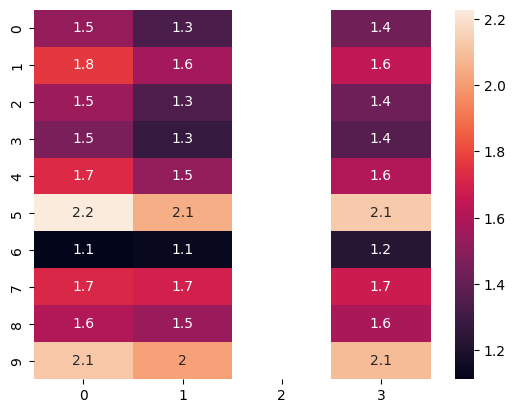

In [128]:
import math
# • Comparison between the OD Matrices
def L2_distance( matrix1 , matrix2 ):
 # Ensure matrices have the same dimensions
 assert matrix1.shape == matrix2.shape , "Matrices must have the same dimensions"
 normalized_matrix1 = matrix1 / matrix1.sum( axis =1, keepdims = True )
 normalized_matrix2 = matrix2 / matrix2.sum( axis =1, keepdims = True )

 # Calculate the squared differences between corresponding cells
 squared_diff = np.square( normalized_matrix1 - normalized_matrix2 )
 # Sum the squared differences
 sum_squared_diff = np.sum( squared_diff )
 # Take the square root to obtain the L2 distance
 l2_distance = np.sqrt( sum_squared_diff )
 return l2_distance

distances = [([0]* len( booking_OD_matrix )) for i in range(len( IMQ_OD_matrices ))]

for i, imq in enumerate( IMQ_OD_matrices ):
  for j, rental in enumerate( booking_OD_matrix ):
    distance = L2_distance(imq.values , rental.values )
    distances[i][j] = distance
    
#  plotting the heatmap
hm = sb.heatmap( data =np.array( distances ), annot = True )
#  displaying the plotted heatmap
plt.show()

In [115]:
# # Plotting the OD Matrices
# def plot_matrix( od_matrix , title ):
#  # Create meshgrid for x and y values
#  x, y = np.meshgrid( range( od_matrix.shape[0]) , range( od_matrix.shape[1]) )
#  # Create figure and 3D axes
#  fig = plt.figure(dpi =300 , figsize =(12 , 12))
#  ax = fig.add_subplot(111 , projection ='3d')
#  # Create surface plot
#  ax.plot_surface(x, y, od_matrix , cmap ='inferno')
#  # Set labels and title
#  ax.set_xlabel('Origin ')
#  ax.set_ylabel('Destination ')
#  ax.set_zlabel('Flow ')
#  ax.set_title( title )

#  # Show the plot
#  plt.show()

# for i, element in enumerate( booking_OD_matrix):
#   plot_matrix( booking_OD_matrix[i].values , " ")

# for i, od_matrix in enumerate( IMQ_OD_matrices ):
#   plot_matrix( IMQ_OD_matrices[i].values , " ")

In [125]:
print(distances)
# plot_matrix( distances , " ")

[[1.5287802253842733, 1.3322527081622706, nan, 1.4358163537561057], [1.7627333025526275, 1.56951915845248, nan, 1.640955692192335], [1.547844948255728, 1.3401328435607753, nan, 1.4279568193155283], [1.4585558368574227, 1.2696543450950912, nan, 1.360821970475798], [1.7246522451528528, 1.5247561328701393, nan, 1.602531439118853], [2.2281913135207505, 2.0523422119275017, nan, 2.1320882244108463], [1.1122211379272708, 1.1373796528930225, nan, 1.2275134007460498], [1.7218602122619349, 1.694530595412173, nan, 1.6744939873867388], [1.6014394276121329, 1.540293679076009, nan, 1.5873386235411406], [2.1219949418098585, 2.0160321867391064, nan, 2.088124754811364]]
